# Self-Organizing Map을 이용한 LoRa 심볼 분석

이 노트북에서는 SOM(Self-Organizing Map)을 사용하여 LoRa(Long Range) 심볼의 특성을 분석합니다.

**설정:**
- SF (Spreading Factor): 9
- 노이즈 없음 (Clean Signal)
- 심볼 개수: 2^9 = 512개

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import RegularPolygon
from matplotlib.colors import Normalize
import warnings
warnings.filterwarnings('ignore')

# 상위 폴더의 utils 추가
sys.path.append('..')
sys.path.append('.')

# SOM 모듈 임포트
from som import SelfOrganizingMap
from utils.LoRa import LoRa

# 플롯 설정
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

print("모듈 임포트 완료!")

모듈 임포트 완료!


In [2]:
# 시각화 유틸: rect/hex 격자 모두 지원
def plot_som_background(ax, som, values, cmap='gray_r', alpha=0.35, vmin=None, vmax=None, edgecolor='k', linewidth=0.15):
    """SOM 배경(예: U-matrix)을 topology에 맞게 그려준다."""
    if getattr(som, 'topology', 'rect') == 'hex':
        centers = som.get_neuron_centers()  # (rows, cols, 2) -> [x,y]
        radius = float(getattr(som, 'hex_radius', 1.0))
        patches = []
        color_values = []
        rows, cols = values.shape
        for r in range(rows):
            for c in range(cols):
                x, y = centers[r, c]
                patches.append(RegularPolygon((x, y), numVertices=6, radius=radius, orientation=np.deg2rad(30)))
                color_values.append(float(values[r, c]))
        norm = Normalize(vmin=np.nanmin(values) if vmin is None else vmin, vmax=np.nanmax(values) if vmax is None else vmax)
        pc = PatchCollection(patches, cmap=cmap, norm=norm, edgecolor=edgecolor, linewidths=linewidth, alpha=alpha)
        pc.set_array(np.asarray(color_values))
        ax.add_collection(pc)
        ax.autoscale_view()
        ax.set_aspect('equal')
        ax.invert_yaxis()
        return pc
    else:
        im = ax.imshow(values, cmap=cmap, interpolation='nearest', alpha=alpha, vmin=vmin, vmax=vmax)
        ax.set_aspect('equal')
        ax.invert_yaxis()
        return im

def bmu_positions_to_xy(som, bmu_positions, jitter=0.25, seed=0):
    """BMU (row,col) 배열을 scatter용 (x,y) 좌표로 변환."""
    rng = np.random.default_rng(seed)
    bmu_positions = np.asarray(bmu_positions)
    if getattr(som, 'topology', 'rect') == 'hex':
        centers = som.get_neuron_centers()
        radius = float(getattr(som, 'hex_radius', 1.0))
        jit = rng.uniform(-jitter, jitter, size=(len(bmu_positions), 2)) * radius
        xs = np.array([centers[r, c, 0] for r, c in bmu_positions]) + jit[:, 0]
        ys = np.array([centers[r, c, 1] for r, c in bmu_positions]) + jit[:, 1]
        return xs, ys
    else:
        jit = rng.uniform(-jitter, jitter, size=(len(bmu_positions), 2))
        xs = bmu_positions[:, 1] + jit[:, 0]
        ys = bmu_positions[:, 0] + jit[:, 1]
        return xs, ys

## 11. STFT 기반 멀티-SF SOM 파이프라인

아래 파이프라인은 요청하신 도메인 정의대로, **Baseband(캐리어 제거) → (옵션) dechirp → STFT magnitude → 고정 크기 리사이즈 → 벡터화 → (옵션) PCA → SOM 학습/시각화** 순서로 동작합니다.

목표: SOM이 **chirp 기울기(SF)**에 따른 패턴을 자기조직화로 분리/군집화하도록 유도합니다.

In [3]:
# (필요 라이브러리) STFT + 리사이즈 + (옵션) PCA
from scipy.signal import stft
from scipy.ndimage import zoom
from sklearn.decomposition import PCA

In [4]:
# 기본 파라미터(없으면 여기서 정의)
# 다른 노트북들과 동일하게 LoRa BW는 기본 125 kHz로 둡니다.
if 'BW' not in globals():
    BW = 125e3  # 125 kHz

# SOM 격자 토폴로지(이 노트북에서 사용)
if 'TOPOLOGY' not in globals():
    TOPOLOGY = 'hex'   # 'rect' | 'hex'
if 'HEX_RADIUS' not in globals():
    HEX_RADIUS = 1.0

print(f"BW={BW/1e3:.1f} kHz, TOPOLOGY={TOPOLOGY}, HEX_RADIUS={HEX_RADIUS}")

BW=125.0 kHz, TOPOLOGY=hex, HEX_RADIUS=1.0


In [5]:
# 파이프라인 설정값 (일단: 노이즈 없음 + SF=9 고정)
SF_FIXED = 9                         # 고정 SF
SAMPLES_PER_SF = 2 ** SF_FIXED        # SF=9이면 512개 codeword 전부 사용
USE_DECHIRP = True                   # dechirp 후 STFT가 더 정보가 잘 드러나는 편
FS = BW                              # 프로젝트에서 사용한 가정(Fs≈BW)

# [핵심] ROI 추출/정렬(Align) 설정
# 지금은 생성한 심볼이 이미 심볼 경계가 정확하므로(노이즈/지연 없음) OFF가 더 깔끔합니다.
ENABLE_ALIGN = False                 # Energy detection으로 시작점 맞추기
ENERGY_WIN = 32                      # 에너지 평활(window) 길이(샘플)
ENERGY_THR_RATIO = 0.10              # threshold = ratio * max(energy)
ROI_MODE = 'symbol'                  # 'symbol' (심볼 길이) 또는 'fixed'
ROI_LEN_FIXED = 512                  # ROI_MODE='fixed'일 때만 사용

# (테스트용) 랜덤 도착 지연 시뮬레이션 (요청: 일단 OFF)
SIMULATE_RANDOM_DELAY = False
MAX_DELAY_SAMPLES = 256              # 0-padding 지연(샘플)

# STFT 설정
NPERSEG = 64
NOVERLAP = 32
NFFT = 256
F_BINS = 64                          # 주파수축 고정 크기
T_BINS = 32                          # 시간축 고정 크기
DB_CLIP = (-60, 0)                   # dB dynamic range 고정
EPS = 1e-12

# (옵션) 차원 축소
USE_PCA = True
PCA_DIM = 64                         # SOM 입력 차원(추천 32~128)

# SOM 설정(STFT용)
MAP_SIZE_STFT = (24, 24)
SIGMA_STFT = max(MAP_SIZE_STFT) / 2
LR_STFT = 0.5
NUM_ITER_STFT = 10000                # 너무 크면 오래 걸림(먼저 5k~10k 추천)

print("[STFT-SOM Pipeline Config]")
print(f"  SF_FIXED={SF_FIXED}, N_codewords={SAMPLES_PER_SF}")
print(f"  Clean(no noise) = True")
print(f"  USE_DECHIRP={USE_DECHIRP}")
print(f"  ALIGN={ENABLE_ALIGN}, SIM_DELAY={SIMULATE_RANDOM_DELAY}, ROI_MODE={ROI_MODE}")
print(f"  STFT: nperseg={NPERSEG}, noverlap={NOVERLAP}, nfft={NFFT}, target={F_BINS}x{T_BINS}")
print(f"  PCA: {USE_PCA} (dim={PCA_DIM})")
print(f"  SOM: map={MAP_SIZE_STFT}, iters={NUM_ITER_STFT}, topology={TOPOLOGY}")

def _smooth_moving_average(x, win):
    if win <= 1:
        return x
    k = np.ones(int(win), dtype=float) / float(win)
    return np.convolve(x, k, mode='same')

def find_signal_start_energy(x, win=32, thr_ratio=0.10):
    """에너지 기반 시작점 검출(가벼운 energy detection)."""
    e = np.abs(x) ** 2
    e_s = _smooth_moving_average(e, win)
    thr = float(thr_ratio) * float(np.max(e_s) + 1e-12)
    idx = np.argmax(e_s > thr)
    if e_s[idx] <= thr:
        return 0
    return int(idx)

def align_and_crop(x, start_idx, roi_len):
    """start_idx로 정렬 후 roi_len만큼 자르고 부족하면 0-pad."""
    x2 = x[start_idx:]
    if roi_len is None:
        return x2
    roi_len = int(roi_len)
    if len(x2) >= roi_len:
        return x2[:roi_len]
    pad = np.zeros(roi_len - len(x2), dtype=x2.dtype)
    return np.concatenate([x2, pad])

def stft_mag_vector(x, fs, nperseg, noverlap, nfft, f_bins, t_bins, db_clip=DB_CLIP, eps=EPS):
    """complex baseband 1D -> (fixed-size) STFT log-magnitude vector."""
    _, _, Zxx = stft(
        x, fs=fs, window='hann', nperseg=nperseg, noverlap=noverlap,
        nfft=nfft, return_onesided=False, boundary=None, padded=False,
    )
    S = np.abs(Zxx)
    # 주파수축을 중심(0Hz) 기준으로 정렬
    S = np.fft.fftshift(S, axes=0)
    # log-magnitude (dB) + clipping
    S_db = 20 * np.log10(S + eps)
    if db_clip is not None:
        S_db = np.clip(S_db, db_clip[0], db_clip[1])
    # (F,T) -> fixed (f_bins, t_bins) via resize
    zf = f_bins / max(S_db.shape[0], 1)
    zt = t_bins / max(S_db.shape[1], 1)
    S_rs = zoom(S_db, (zf, zt), order=1)
    # 안전하게 목표 크기에 맞춰 crop/pad
    S_out = np.zeros((f_bins, t_bins), dtype=np.float32)
    ff = min(f_bins, S_rs.shape[0])
    tt = min(t_bins, S_rs.shape[1])
    S_out[:ff, :tt] = S_rs[:ff, :tt]
    v = S_out.reshape(-1).astype(np.float32)
    # per-sample normalize
    v = (v - v.mean()) / (v.std() + 1e-8)
    return v

[STFT-SOM Pipeline Config]
  SF_FIXED=9, N_codewords=512
  Clean(no noise) = True
  USE_DECHIRP=True
  ALIGN=False, SIM_DELAY=False, ROI_MODE=symbol
  STFT: nperseg=64, noverlap=32, nfft=256, target=64x32
  PCA: True (dim=64)
  SOM: map=(24, 24), iters=10000, topology=hex


In [6]:
# 데이터셋 생성: (SF=9 고정, codeword 0..511) -> STFT feature
X_stft = []
y_codeword = []

rng = np.random.default_rng(0)

l = LoRa(sf=SF_FIXED, bw=BW, OSF=1)
n_sym = 2 ** SF_FIXED
codes = np.arange(n_sym, dtype=int)  # 0..511 전부
ref_down_sf = l.gen_symbol(0, down=True) if USE_DECHIRP else None

for cw in codes:
    s = l.gen_symbol(int(cw), down=False)  # clean baseband symbol (no noise)
    sym_len = len(s)

    # (테스트/현실 반영) 도착 지연: 앞에 0을 붙여 비동기 도착을 모사 (요청: OFF)
    if SIMULATE_RANDOM_DELAY:
        d = int(rng.integers(0, MAX_DELAY_SAMPLES + 1))
        if d > 0:
            s = np.concatenate([np.zeros(d, dtype=s.dtype), s])

    # Align/ROI (요청: 일단 OFF, 그래도 옵션은 남김)
    if ENABLE_ALIGN:
        start = find_signal_start_energy(s, win=ENERGY_WIN, thr_ratio=ENERGY_THR_RATIO)
        if ROI_MODE == 'fixed':
            roi_len = ROI_LEN_FIXED
        else:
            roi_len = sym_len
        s = align_and_crop(s, start_idx=start, roi_len=roi_len)
    else:
        # 심볼 생성은 이미 심볼 길이가 고정이므로 그대로 사용
        if ROI_MODE == 'fixed':
            s = s[:ROI_LEN_FIXED] if len(s) >= ROI_LEN_FIXED else np.pad(s, (0, ROI_LEN_FIXED-len(s)))
        else:
            s = s[:sym_len]

    # (옵션) dechirp는 align/ROI 이후에 적용(길이 일치 보장)
    if USE_DECHIRP:
        ref = ref_down_sf
        if len(s) != len(ref):
            if len(ref) >= len(s):
                ref = ref[:len(s)]
            else:
                ref = np.concatenate([ref, np.zeros(len(s)-len(ref), dtype=ref.dtype)])
        s = s * ref

    v = stft_mag_vector(
        s, fs=FS, nperseg=NPERSEG, noverlap=NOVERLAP, nfft=NFFT,
        f_bins=F_BINS, t_bins=T_BINS, db_clip=DB_CLIP, eps=EPS,
    )
    X_stft.append(v)
    y_codeword.append(int(cw))

X_stft = np.vstack(X_stft)
y_codeword = np.asarray(y_codeword)

print(f"X_stft shape: {X_stft.shape}")
print(f"codeword range: {y_codeword.min()}..{y_codeword.max()}")
print(f"example codewords: {y_codeword[:10]}")

X_stft shape: (512, 2048)
codeword range: 0..511
example codewords: [0 1 2 3 4 5 6 7 8 9]


In [7]:
# (옵션) PCA로 차원 축소 후 SOM 학습
if USE_PCA and PCA_DIM < X_stft.shape[1]:
    pca = PCA(n_components=PCA_DIM, random_state=42)
    X_in = pca.fit_transform(X_stft)
    print(f"PCA: {X_stft.shape[1]} -> {X_in.shape[1]}")
    print(f"Explained variance ratio sum: {pca.explained_variance_ratio_.sum():.4f}")
else:
    X_in = X_stft
    print("PCA skipped.")

som_stft = SelfOrganizingMap(
    map_size=MAP_SIZE_STFT,
    input_dim=X_in.shape[1],
    sigma=SIGMA_STFT,
    learning_rate=LR_STFT,
    decay_function='exponential',
    topology=TOPOLOGY,
    hex_radius=HEX_RADIUS,
    random_seed=42
 )

print("STFT-SOM 학습 시작...\n")
som_stft.train(X_in, num_iterations=NUM_ITER_STFT, verbose=True)
print("\n학습 완료!")

print(f"Quantization Error: {som_stft.quantization_error(X_in):.4f}")
print(f"Topographic Error: {som_stft.topographic_error(X_in):.4f}")

PCA: 2048 -> 64
Explained variance ratio sum: 1.0000
STFT-SOM 학습 시작...

Iteration 1000/10000 - QE: 36.8496, TE: 0.1250, LR: 0.4525, σ: 9.2875
Iteration 2000/10000 - QE: 32.9709, TE: 0.1504, LR: 0.4094, σ: 7.1863
Iteration 3000/10000 - QE: 28.7761, TE: 0.1562, LR: 0.3704, σ: 5.5604
Iteration 4000/10000 - QE: 22.5315, TE: 0.0469, LR: 0.3352, σ: 4.3024
Iteration 5000/10000 - QE: 17.4489, TE: 0.0078, LR: 0.3033, σ: 3.3291
Iteration 6000/10000 - QE: 12.9713, TE: 0.0176, LR: 0.2744, σ: 2.5759
Iteration 7000/10000 - QE: 9.1180, TE: 0.0215, LR: 0.2483, σ: 1.9931
Iteration 8000/10000 - QE: 7.1958, TE: 0.0625, LR: 0.2247, σ: 1.5422
Iteration 9000/10000 - QE: 5.6685, TE: 0.0449, LR: 0.2033, σ: 1.1933
Iteration 10000/10000 - QE: 4.7429, TE: 0.0703, LR: 0.1840, σ: 0.9233

학습 완료!
Quantization Error: 4.7429
Topographic Error: 0.0703


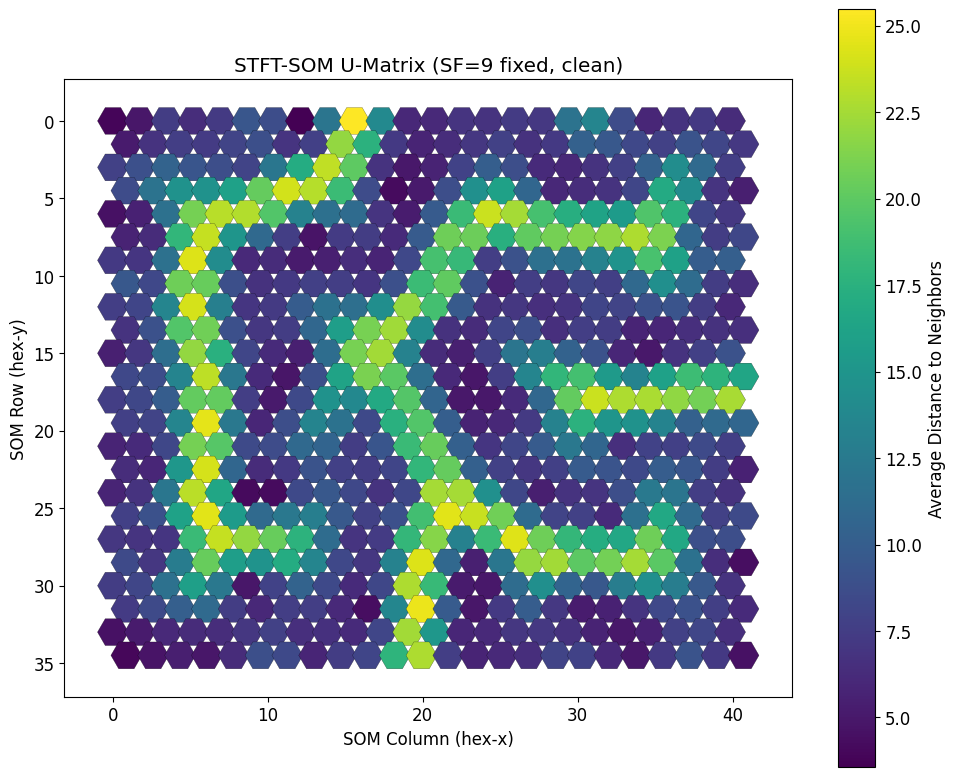

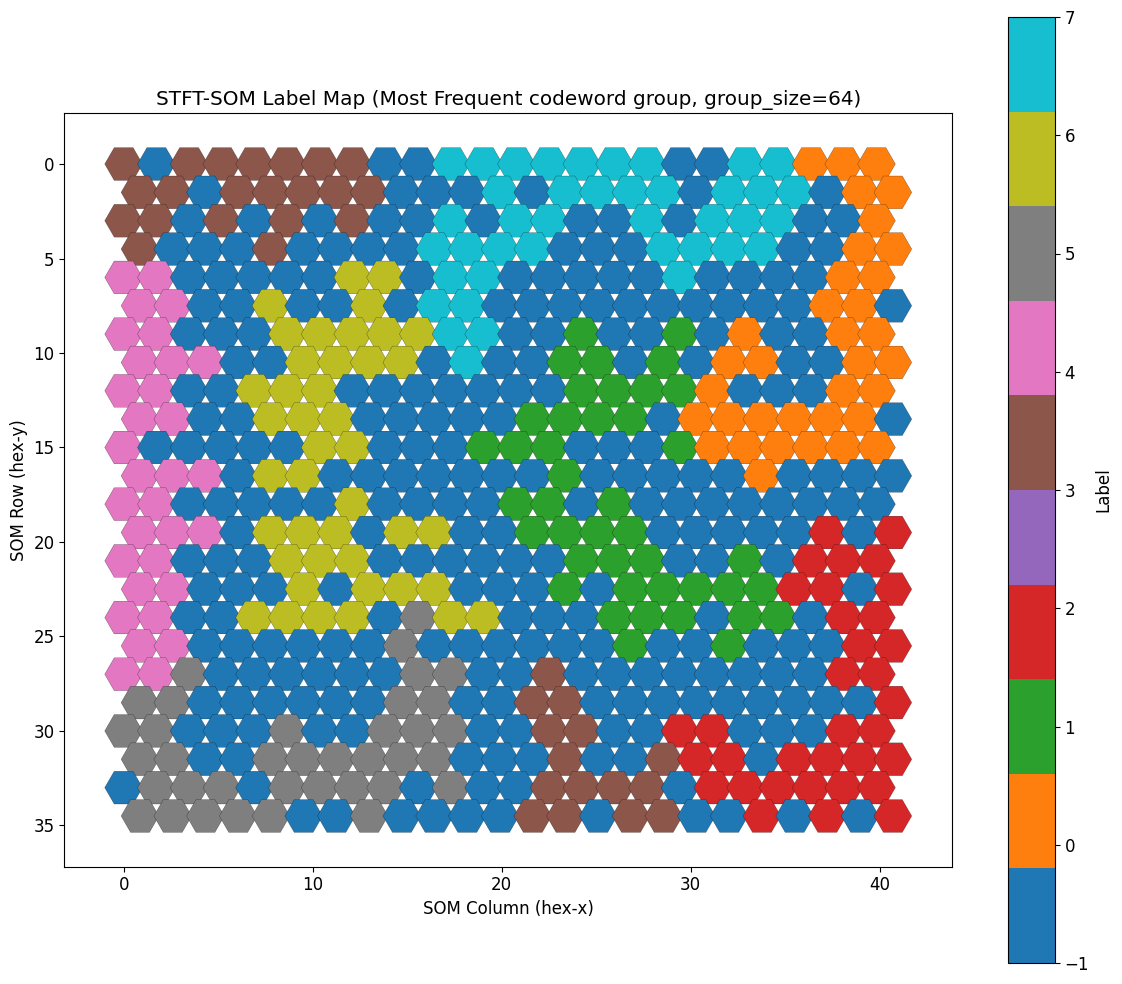

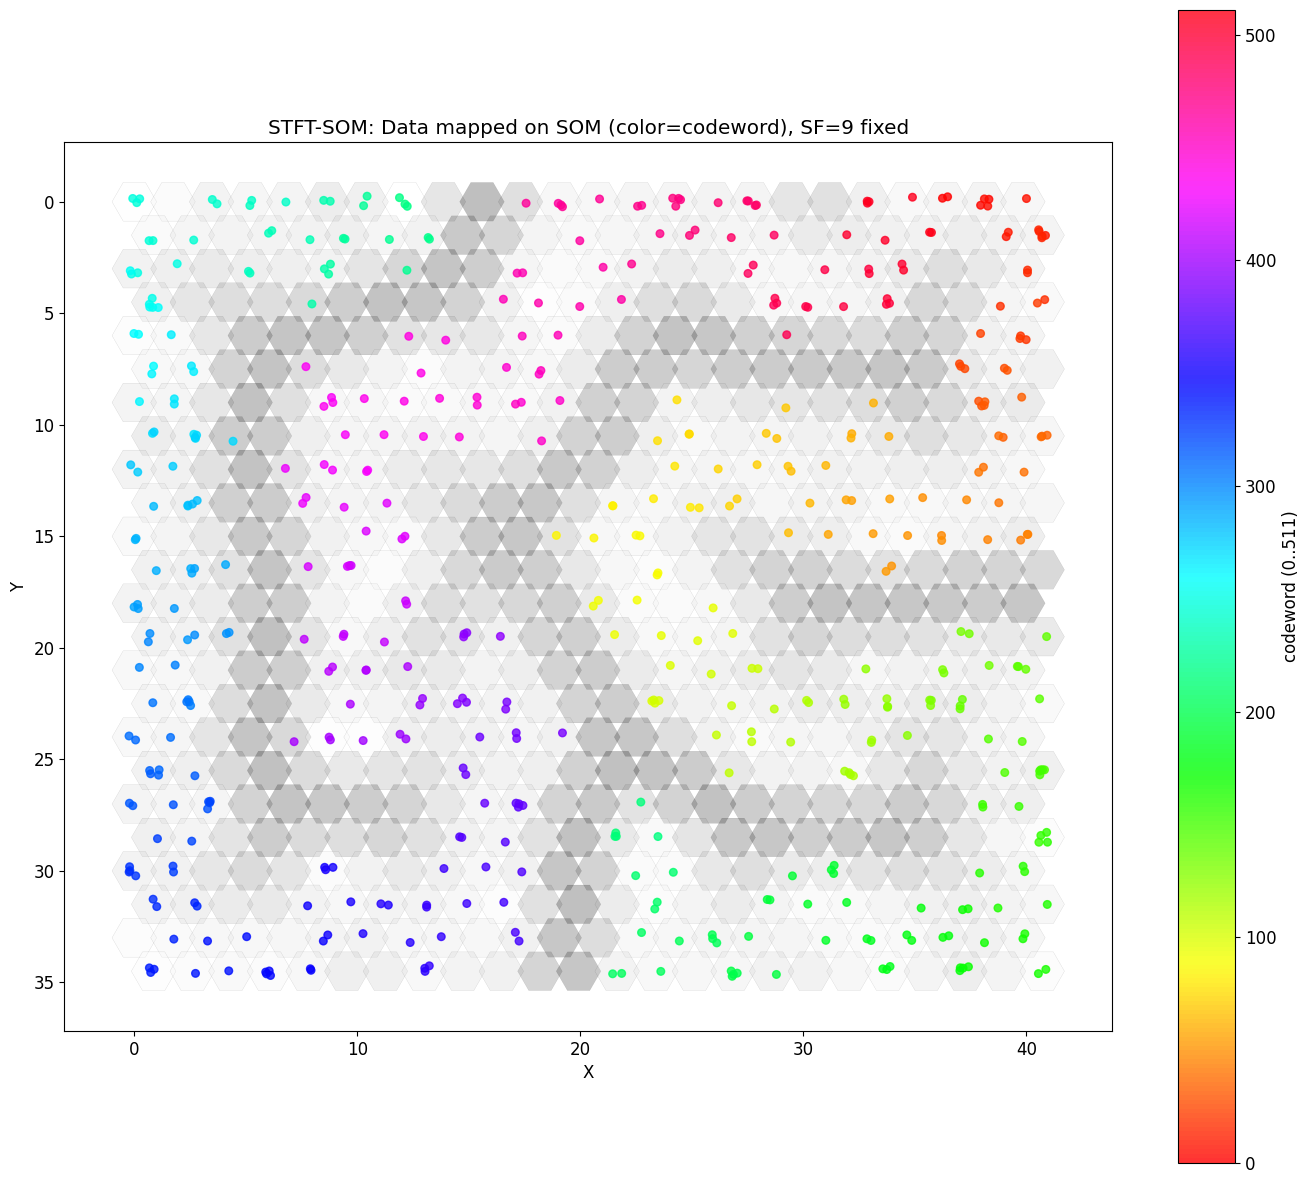

In [8]:
# 결과 시각화: codeword 라벨 맵 + 데이터 산점도
fig, ax = som_stft.plot_u_matrix(figsize=(10, 8), cmap='viridis')
plt.title('STFT-SOM U-Matrix (SF=9 fixed, clean)')
plt.show()

# codeword는 0..511이라 그대로 라벨맵을 그리면 너무 촘촘할 수 있어, 그룹(예: 64개 단위)도 같이 봅니다.
group_size = 64
y_group = (y_codeword // group_size).astype(int)

fig, ax = som_stft.plot_winner_map(X_in, labels=y_group, figsize=(12, 10), cmap='tab10')
plt.title(f'STFT-SOM Label Map (Most Frequent codeword group, group_size={group_size})')
plt.show()

# 데이터 포인트를 SOM 위에(색=codeword)
bmu_pos_stft = np.array([som_stft.predict(x) for x in X_in])
fig, ax = plt.subplots(figsize=(14, 12))
u = som_stft.get_u_matrix()
plot_som_background(ax, som_stft, u, cmap='gray_r', alpha=0.25)
xs, ys = bmu_positions_to_xy(som_stft, bmu_pos_stft, jitter=0.25, seed=123)
sc = ax.scatter(xs, ys, c=y_codeword, cmap='hsv', alpha=0.80, s=30)
plt.colorbar(sc, ax=ax, label='codeword (0..511)')
ax.set_title('STFT-SOM: Data mapped on SOM (color=codeword), SF=9 fixed')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.tight_layout()
plt.show()

# 참고: SF가 하나로 고정이므로, 이전의 SF purity 같은 지표는 여기서는 의미가 없습니다.

## SOM 가중치(STFT 프로토타입) 시각화

> MNIST 예제의 “프로토타입(가중치) 타일 시각화”처럼, STFT-SOM의 각 뉴런 가중치를 **(F_BINS × T_BINS)** STFT 이미지로 되돌려 한 장의 큰 캔버스로 그립니다.

- `USE_PCA=True`인 경우: `pca.inverse_transform`으로 STFT 벡터 공간으로 복원 후 시각화
- `USE_PCA=False`인 경우: `som_stft.weights`가 이미 STFT 벡터 차원이라 바로 시각화

Prototype tensor: (24, 24, 64, 32) (rows, cols, F, T)


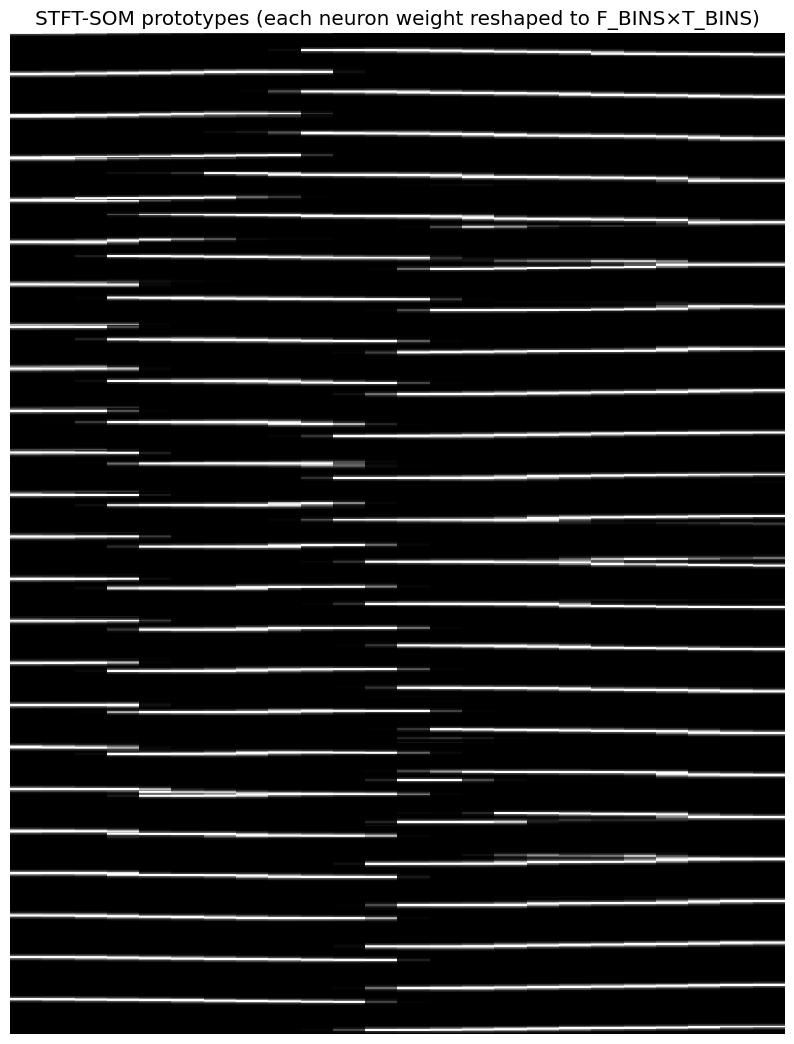

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def _weights_to_stft_prototypes(som, f_bins, t_bins):
    """
    som.weights -> (rows, cols, f_bins, t_bins) 로 복원.
    PCA를 사용했다면(pca 객체가 있으면) inverse_transform 후 복원.
    """
    if 'som_stft' not in globals():
        raise RuntimeError("som_stft가 없습니다. STFT-SOM 학습 셀까지 먼저 실행하세요.")
    rows, cols, dim = som.weights.shape
    W = som.weights.reshape(rows * cols, dim)
    target_dim = int(f_bins) * int(t_bins)

    # PCA 공간(예: 64차원)에서 학습했다면 inverse_transform 필요
    if W.shape[1] != target_dim:
        if 'pca' not in globals():
            raise RuntimeError(
                f"가중치 차원={W.shape[1]}인데 (F_BINS*T_BINS)={target_dim}가 아닙니다. "
                "USE_PCA=True였다면 pca 객체가 있어야 복원이 가능합니다."
            )
        W = pca.inverse_transform(W)
        if W.shape[1] != target_dim:
            raise RuntimeError(f"PCA inverse 후 차원={W.shape[1]}으로, 기대={target_dim}와 다릅니다. F_BINS/T_BINS 설정을 확인하세요.")

    P = W.reshape(rows, cols, int(f_bins), int(t_bins)).astype(np.float32)
    return P

def show_som_stft_prototypes_tiled(P, map_shape, robust_norm=True, clip_percentile=(2, 98), figsize=(12, 18)):
    """
    P: (rows, cols, F, T) 프로토타입 STFT (dB/normalized 등 어떤 스케일이든 가능)
    각 타일을 보기 좋게 정규화해서 큰 캔버스로 표시.
    """
    rows, cols = map_shape
    assert P.shape[0] == rows and P.shape[1] == cols
    F, T = P.shape[2], P.shape[3]

    canvas = np.zeros((rows * F, cols * T), dtype=np.float32)
    for r in range(rows):
        for c in range(cols):
            img = P[r, c]
            img = np.asarray(img, dtype=np.float32)
            # 타일별 정규화 (너무 튀는 outlier가 있으면 percentile clip)
            if robust_norm:
                lo, hi = np.percentile(img, clip_percentile)
                if hi > lo:
                    img = np.clip(img, lo, hi)
            mn, mx = float(img.min()), float(img.max())
            if mx > mn:
                img = (img - mn) / (mx - mn)
            canvas[r*F:(r+1)*F, c*T:(c+1)*T] = img

    plt.figure(figsize=figsize)
    plt.imshow(canvas, cmap='gray', interpolation='nearest', aspect='auto')
    plt.axis('off')
    plt.title('STFT-SOM prototypes (each neuron weight reshaped to F_BINS×T_BINS)')
    plt.show()

# --- 실행 ---
if 'som_stft' not in globals():
    raise RuntimeError("som_stft가 없습니다. 위에서 STFT-SOM 학습을 먼저 완료하세요.")

# F_BINS/T_BINS는 파이프라인 설정값을 그대로 사용
if 'F_BINS' not in globals() or 'T_BINS' not in globals():
    raise RuntimeError("F_BINS/T_BINS가 없습니다. STFT 파이프라인 설정 셀을 먼저 실행하세요.")

P = _weights_to_stft_prototypes(som_stft, f_bins=F_BINS, t_bins=T_BINS)
rows, cols = P.shape[0], P.shape[1]
print('Prototype tensor:', P.shape, '(rows, cols, F, T)')

# 맵이 (24,24)면 캔버스가 커질 수 있어 figsize만 적당히 조절
fig_h = max(10, int(rows * 0.55))
fig_w = max(10, int(cols * 0.45))
show_som_stft_prototypes_tiled(P, map_shape=(rows, cols), robust_norm=True, figsize=(fig_w, fig_h))

## 단일 샘플(STFT)만 보기

> 전체 뉴런 프로토타입 타일 대신, **원하는 codeword 1개**만 뽑아서 STFT 이미지로 확인합니다. (옵션) SOM이 찾은 BMU 프로토타입과 나란히 비교도 가능합니다.

Single sample codeword=144
  STFT raw shape    = (64, 32)
  STFT dechirp shape = (64, 32)
  SOM train input uses dechirp = True
  BMU position: (row=16, col=22)


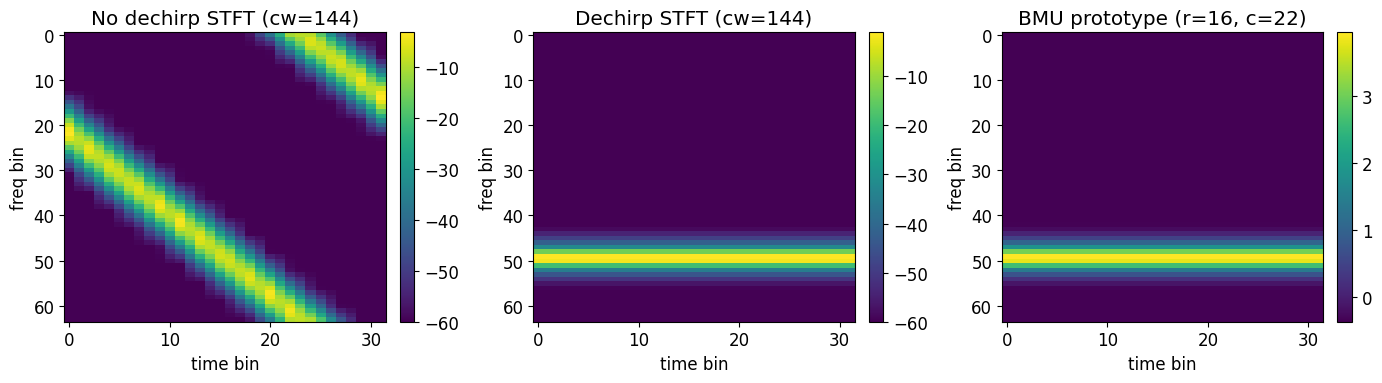

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 보고 싶은 codeword 하나만 지정하세요 (0..511)
SAMPLE_CODEWORD = 144  # <-- 여기만 바꾸면 됩니다.
SHOW_BMU_PROTOTYPE = True  # SOM 학습이 되어 있으면, BMU 프로토타입도 같이 표시

def stft_mag_image(x, fs, nperseg, noverlap, nfft, f_bins, t_bins, db_clip=DB_CLIP, eps=EPS):
    """complex baseband 1D -> (fixed-size) STFT log-magnitude (dB) image (F,T)."""
    from scipy.signal import stft
    from scipy.ndimage import zoom

    _, _, Zxx = stft(
        x, fs=fs, window='hann', nperseg=nperseg, noverlap=noverlap,
        nfft=nfft, return_onesided=False, boundary=None, padded=False,
    )
    S = np.abs(Zxx)
    S = np.fft.fftshift(S, axes=0)
    S_db = 20 * np.log10(S + eps)
    if db_clip is not None:
        S_db = np.clip(S_db, db_clip[0], db_clip[1])

    zf = f_bins / max(S_db.shape[0], 1)
    zt = t_bins / max(S_db.shape[1], 1)
    S_rs = zoom(S_db, (zf, zt), order=1)

    S_out = np.zeros((int(f_bins), int(t_bins)), dtype=np.float32)
    ff = min(int(f_bins), S_rs.shape[0])
    tt = min(int(t_bins), S_rs.shape[1])
    S_out[:ff, :tt] = S_rs[:ff, :tt]
    return S_out

def _ensure_len_match(a, b):
    if len(a) == len(b):
        return a, b
    if len(a) > len(b):
        a = a[:len(b)]
    else:
        b = b[:len(a)]
    return a, b

# --- 단일 샘플 생성 (파이프라인과 동일한 전처리 옵션 반영)
if 'SF_FIXED' not in globals():
    raise RuntimeError("SF_FIXED가 없습니다. STFT 파이프라인 설정 셀을 먼저 실행하세요.")
if 'BW' not in globals() or 'FS' not in globals():
    raise RuntimeError("BW/FS가 없습니다. 기본 파라미터 셀 + 파이프라인 설정 셀을 먼저 실행하세요.")

cw = int(SAMPLE_CODEWORD)
l = LoRa(sf=SF_FIXED, bw=BW, OSF=1)
s_raw = l.gen_symbol(cw, down=False)
sym_len = len(s_raw)

# Align/ROI 옵션 (앞에서 만든 함수/플래그 재사용)
if 'ENABLE_ALIGN' in globals() and ENABLE_ALIGN:
    start = find_signal_start_energy(s_raw, win=ENERGY_WIN, thr_ratio=ENERGY_THR_RATIO)
    roi_len = ROI_LEN_FIXED if ROI_MODE == 'fixed' else sym_len
    s_raw = align_and_crop(s_raw, start_idx=start, roi_len=roi_len)
else:
    if 'ROI_MODE' in globals() and ROI_MODE == 'fixed':
        if len(s_raw) >= ROI_LEN_FIXED:
            s_raw = s_raw[:ROI_LEN_FIXED]
        else:
            s_raw = np.pad(s_raw, (0, ROI_LEN_FIXED - len(s_raw)))
    else:
        s_raw = s_raw[:sym_len]

# 디처프 버전도 항상 같이 생성
ref = l.gen_symbol(0, down=True)
s_raw2, ref2 = _ensure_len_match(s_raw, ref)
s_dechirp = s_raw2 * ref2

# STFT 이미지(미디처프 vs 디처프)
img_raw = stft_mag_image(
    s_raw, fs=FS, nperseg=NPERSEG, noverlap=NOVERLAP, nfft=NFFT,
    f_bins=F_BINS, t_bins=T_BINS, db_clip=DB_CLIP, eps=EPS,
 )
img_dechirp = stft_mag_image(
    s_dechirp, fs=FS, nperseg=NPERSEG, noverlap=NOVERLAP, nfft=NFFT,
    f_bins=F_BINS, t_bins=T_BINS, db_clip=DB_CLIP, eps=EPS,
 )

# SOM 학습이 어떤 입력으로 되었는지(파이프라인 플래그)
TRAIN_USES_DECHIRP = bool(globals().get('USE_DECHIRP', True))
s_for_bmu = s_dechirp if TRAIN_USES_DECHIRP else s_raw

print(f"Single sample codeword={cw}")
print(f"  STFT raw shape    = {img_raw.shape}")
print(f"  STFT dechirp shape = {img_dechirp.shape}")
print(f"  SOM train input uses dechirp = {TRAIN_USES_DECHIRP}")

if SHOW_BMU_PROTOTYPE and ('som_stft' in globals()):
    # 학습에 들어간 벡터(정규화 포함)를 동일하게 만들어 BMU를 찍습니다.
    v = stft_mag_vector(
        s_for_bmu, fs=FS, nperseg=NPERSEG, noverlap=NOVERLAP, nfft=NFFT,
        f_bins=F_BINS, t_bins=T_BINS, db_clip=DB_CLIP, eps=EPS,
    )
    x_in = v.reshape(1, -1)
    if 'USE_PCA' in globals() and USE_PCA and ('pca' in globals()):
        x_in = pca.transform(x_in)

    bmu_r, bmu_c = som_stft.predict(x_in[0])
    print(f"  BMU position: (row={bmu_r}, col={bmu_c})")

    # BMU 프로토타입을 STFT 이미지로 복원
    w = som_stft.weights[bmu_r, bmu_c].reshape(1, -1)
    if w.shape[1] != (F_BINS * T_BINS):
        if 'pca' in globals():
            w = pca.inverse_transform(w)
    w_img = w.reshape(F_BINS, T_BINS).astype(np.float32)

    fig, axs = plt.subplots(1, 3, figsize=(14, 4))
    im0 = axs[0].imshow(img_raw, cmap='viridis', aspect='auto')
    axs[0].set_title(f"No dechirp STFT (cw={cw})")
    axs[0].set_xlabel('time bin')
    axs[0].set_ylabel('freq bin')
    plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

    im1 = axs[1].imshow(img_dechirp, cmap='viridis', aspect='auto')
    axs[1].set_title(f"Dechirp STFT (cw={cw})")
    axs[1].set_xlabel('time bin')
    axs[1].set_ylabel('freq bin')
    plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

    im2 = axs[2].imshow(w_img, cmap='viridis', aspect='auto')
    axs[2].set_title(f"BMU prototype (r={bmu_r}, c={bmu_c})")
    axs[2].set_xlabel('time bin')
    axs[2].set_ylabel('freq bin')
    plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()
else:
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    im0 = axs[0].imshow(img_raw, cmap='viridis', aspect='auto')
    axs[0].set_title(f"No dechirp STFT (cw={cw})")
    axs[0].set_xlabel('time bin')
    axs[0].set_ylabel('freq bin')
    plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

    im1 = axs[1].imshow(img_dechirp, cmap='viridis', aspect='auto')
    axs[1].set_title(f"Dechirp STFT (cw={cw})")
    axs[1].set_xlabel('time bin')
    axs[1].set_ylabel('freq bin')
    plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()